<a href="https://colab.research.google.com/github/teoalcdor/tfg_teoalcdor/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net

En este notebook vamos a utilizar una UNet par resolver el problema planteado en nuestro dataset de segmentación. Para la primera mitad de la U-Net, la parte "descendente", vamos utilizar un modelo VGG16 pre-entrenado, mientras que la parte "ascendente" la construiremos y entrenaremos nosotros desde cero.

## Librerías

Comenzamos cargando instalando las librerías necesarias:

In [ ]:
!pip install torchinfo

In [ ]:
import copy
import cv2
from glob import glob
from google.colab import drive
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import models, transforms
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.ops import nms
import tqdm

In [ ]:
%matplotlib inline

Tratamos de utilizar la GPU

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


## Funciones Auxiliares

Definimos las funciones que vamos a utilizar para el entrenamiento y la representación de los resultados:

In [ ]:
def segmentation_loss(preds, targets):
    """
    Pérdida de entropía cruzada binaria y accuracy de U-Net para un batch
    """
    loss = nn.CrossEntropyLoss()(preds, targets)
    accuracy = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, accuracy


def train_batch(model, data, optimizer, criterion):
    """
    Entrena el modelo en un batch.
    """

    model.train() # Modo entrenamiento

    # Obtenemos la prediccion con propagacion hacia delante (logits)
    ims, masks = data

    # Calculamos el gradiente de la perdida con retropropagacion
    _masks = model(ims)

    # Obtenemos la perdida
    loss, accuracy = criterion(_masks, masks)
    loss.backward()

    # Hacemos un paso del metodo del gradiente
    optimizer.step()

    # Vaciamos el optimizador de la informacion del gradiente
    optimizer.zero_grad()

    return loss.item(), accuracy.item()  # Retornamos el numero, no un tensor


@torch.no_grad()
def validate_batch(model, data, criterion):
    """
    Calcula la pérdida del modelo en el conjunto de validación.
    """

    model.eval() # Modo inferencia

    # Obtenemos la prediccion con propagacion hacia delante (logits)
    ims, masks = data
    _masks = model(ims)

    # Obtenemos la perdida
    loss, accuracy = criterion(_masks, masks)

    return loss.item(), accuracy.item() # Retornamos el numero, no un tensor


def train_model(model, optimizer, train_dataloader, val_dataloader, criterion, epochs=10):
    """
    Entrena el modelo, implementando un mecanismo que actúa como early stopping basado en
    la accuracy en validación. Devuelve también las pérdida y accuracy encontradas en
    los conjuntos de entrenamiento y valiación durante el entrenamiento.
    """

    # Inicializamos las listas con las perdidas y accuracies
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Inicializamos el mecanismo de early stopping
    best_model = {
        "model_state_dict": None,
        "optimizer_state_dict": None,
        "epoch": None,
        "max_val_accuracy": -1
    }

    for epoch in range(epochs):

        # Regristramos el momento de comienzo de la epoch
        year, month, day, h, m, s = map(lambda x : x.rjust(2, "0"),
                                          time.strftime("%y %m %d %H %M %S")
                                          .split())
        time_stamp = f"{day}/{month}/{year} {h}:{m}:{s}"
        start = time.time()
        print("=" * 80)
        print(f"Epoch: {epoch + 1} - Started: {time_stamp}")

        # Inicializamos las listas con las perdidas y accuracies de la epoch
        train_epoch_loss, train_epoch_accuracy = [], []
        val_epoch_loss, val_epoch_accuracy = [], []

        # Entrenamos el modelo con minibatch
        _n = len(train_dataloader)
        for _, inputs in tqdm.tqdm(enumerate(train_dataloader), total=_n, desc="- Training"):
            loss, accuracy = train_batch(model, inputs, optimizer, criterion)
            train_epoch_loss.append(loss)
            train_epoch_accuracy.append(accuracy)

        # Calculamos la perdida y la accuracy sobre el conjunto de validacion
        _n = len(val_dataloader)
        for _, inputs in tqdm.tqdm(enumerate(val_dataloader), total=_n, desc="- Validation"):
            loss, accuracy = validate_batch(model, inputs, criterion)
            val_epoch_loss.append(loss)
            val_epoch_accuracy.append(accuracy)

        # Actualizamos las perdidas y accuracies
        train_losses.append(np.mean(train_epoch_loss))
        train_accuracies.append(np.mean(train_epoch_accuracy))
        val_losses.append(np.mean(val_epoch_loss))
        val_accuracies.append(np.mean(val_epoch_accuracy))

        # Ponemos en marcha el mecanismo de early stopping
        if val_accuracies[-1] > best_model["max_val_accuracy"]:
            best_model["max_val_accuracy"] = val_accuracies[-1]
            best_model["model_state_dict"] = copy.deepcopy(model.state_dict())
            best_model["optimizer_state_dict"] = copy.deepcopy(optimizer.state_dict())
            best_model["epoch"] = epoch + 1

        # Regristramos el momento de comienzo de la epoch
        end = time.time()
        year, month, day, h, m, s = map(lambda x : x.rjust(2, "0"),
                                        time.strftime("%y %m %d %H %M %S")
                                        .split())
        time_stamp = f"{day}/{month}/{year} {h}:{m}:{s}"

        print(f"Epoch: {epoch + 1} - Ended: {time_stamp} - Duration: {round(end - start, 2)}s")
        print()

        # Imprimimos estadisticas de la epoch para un mejor seguimiento
        print(f"Training Loss: {train_losses[-1]} - Validation Loss: {val_losses[-1]}")
        print(f"Training Accuracy: {train_accuracies[-1]} - Validation Accuracy: {val_accuracies[-1]}")
        print("=" * 80)
        print()

    return train_losses, train_accuracies, val_losses, val_accuracies, best_model


def plot_training_results(train_losses, val_losses,
                          train_accuracies, val_accuracies, title):
    """
    Representa la pérdida y accuracy del modelo en el entrenamiento sobre
    los conjuntos de entrenamiento y validación.
    """

    # Diccionario con las perdidas
    losses_results = pd.DataFrame(
        {f"Entrenamiento": train_losses,
         f"Validación": val_losses})
    accuracies_results = pd.DataFrame(
        {f"Entrenamiento": train_accuracies,
         f"Validación": val_accuracies})

    with sns.axes_style("whitegrid"):
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        # Grafica de las perdidas
        losses_results_plot = sns.lineplot(data=losses_results, ax = axs[0])
        axs[0].set_ylabel("Pérdida", fontsize=17)
        axs[0].set_xlabel("Epochs", fontsize=17)
        axs[0].set_xticks([0, 4, 9, 14, 19, 24])
        axs[0].set_xticklabels([1, 5, 10, 15, 20, 25], fontsize=12)
        axs[0].tick_params(axis='y', labelsize=12)

        # Grafica de las accuracies
        accuracies_results_plot = sns.lineplot(data=accuracies_results, ax = axs[1])
        axs[1].set_xticks([0, 4, 9, 14, 19, 24])
        axs[1].set_xticklabels([1, 5, 10, 15, 20, 25], fontsize=12)
        axs[1].set_ylabel("Accuracy", fontsize=17)
        axs[1].set_xlabel("Epochs", fontsize=17)
        axs[1].tick_params(axis='y', labelsize=12)

        fig.suptitle(title, fontsize=20)
        plt.tight_layout()
        plt.show()


def create_class_colors(num_classes, seed):
    """
    Crea un diccionario con los colores de cada clase elegidos de forma
    aleatoria.
    """

    # Reproducibilidad
    np.random.seed(seed)

    # Inicializacion
    class_colors = {}

    # Para cada clase, creamos su color
    for i in range(num_classes):

        # Mientras no aceptemos el color creado para la clase, seguimos creando
        # colores
        not_accepted = True
        while not_accepted:

            # Elegimos el valor para cada canal
            r = np.random.randint(0, 255)
            g = np.random.randint(0, 255)
            b = np.random.randint(0, 255)

            # El color no debe ser muy gris
            not_gray = abs(r - g) > 50 or abs(r - b) > 50 and abs(g - b) > 50

            # El color no debe ser muy blanco
            not_white = r < 230 and g < 230 and b < 230

            # Si no es muy gris ni muy blanco, lo aceptamos
            if not_gray and not_white :
                not_accepted = False
                class_colors[i] = (r, g, b)

    # Si no es muy gris ni muy blanco, lo aceptamos
    mapping_matrix = np.zeros((num_classes + 1, 3), dtype=np.uint8)
    for class_id, color in class_colors.items():
        mapping_matrix[class_id + 1] = color

    return class_colors, mapping_matrix

MAPPING_MATRIX = create_class_colors(9, 123)[1]


def color_mask(mask, mapping_matrix):
    """
    Transforma una mascara de clases en una imagen coloreada de la mascara.
    """

    colored_mask = mapping_matrix[mask]

    return colored_mask


def decode_pred_mask(pred_mask):
    """
    Convierte el una prediccion en una máscara (de un solo canal)
    """
    decoded_mask = torch.max(pred_mask[0], 0)[1].int()
    return decoded_mask


@torch.no_grad()
def measure_fps_unet(model, dataset, dataloader):
    """
    Estima los FPS a los que detecta SSD300. Se tiene el cuenta el
    post-procesamiento.
    """

    model.eval() # Modo evaluacion
    n = len(dataset)

    # Cronometramos cuanto tardamos en detectar y procesar las detecciones de
    # todas las imagenes
    torch.cuda.synchronize()
    start_time = time.time()

    for images, _ in dataloader:
        pred_masks = model(images)
        for pred_mask in pred_masks:
            _ = decode_pred_mask(pred_mask[None])

    torch.cuda.synchronize()
    total_time = time.time() - start_time

    # Calculamos los FPS
    fps = n / total_time
    print(f"FPS: {fps:.2f}")

    return fps


@torch.no_grad()
def measure_exact_accuracy_unet(model, dataset, dataloader):
    """
    Estima la accuracy exacta de U-Net.
    """

    model.eval() # Modo evaluacion

    _n = len(val_dataloader)

    # Inicializamos el numero de pixeles correctos y el total de pixeles
    correct_pixels = 0
    total_pixels = 640 * 640 * len(val_dataset)

    # Para cada imagen, contamos el numero de pixeles correctos y los acumulamos
    for images, masks in tqdm.tqdm(val_dataloader, total=_n):
        pred_masks = model(images)
        for i, pred_mask in enumerate(pred_masks):
            decoded_pred_mask = decode_pred_mask(pred_mask[None])
            correct_pixels += torch.sum(decoded_pred_mask == masks[i]).item()

    # Calculamos la accuracy y la imprimimos
    accuracy = correct_pixels / total_pixels
    print()
    print(f"Accuracy: {round(accuracy, 4)}")
    return accuracy

@torch.no_grad()
def predict_unet(image, model):
    """
    Realiza una prediccion con un modelo U-Net.
    """

    model.eval() # Modo Inferencia
    image = STANDARD_TRANSFORM(image) # Transforma la imagen
    pred_mask = model(image[None].float().to(DEVICE)) # Predice
    decoded_pred_mask = decode_pred_mask(pred_mask) # Decodifica la prediccion

    return decoded_pred_mask.to("cpu").numpy()


def get_model_fcn(num_classes):
    """
    Nos permite obtener un modelo FCN listo para aplicar transfer learning
    (con sus cabezas descongeladas) y su optimizador (Adam).
    """

    # Obtenemos el modelo pre-entrenado
    model = models.segmentation.fcn_resnet50(weights=models.segmentation.FCN_ResNet50_Weights.DEFAULT).to(DEVICE)

    # Congelamos todos los parametros de la backbone
    for param in model.backbone.parameters():
        param.requires_grad = False

    # Instanciamos un objeto de tipo FCNHead adaptado a nuestras necesidades que
    # usamos como clasificador principal
    model.classifier = FCNHead(
        in_channels=model.classifier[0].in_channels,
        channels=num_classes
    ).to(DEVICE)

    # Instanciamos un objeto de tipo FCNHead adaptado a nuestras necesidades que
    # usamos como clasificador secundario
    model.aux_classifier = FCNHead(
        in_channels=model.aux_classifier[0].in_channels,
        channels=num_classes
    ).to(DEVICE)

    # Optimizador: Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    return model.to(DEVICE), optimizer


def create_confusion_matrix_segmentation(true_masks, predicted_masks,
                                         label_encoder,
                                         title="Confusion Matrix"):
    """
    Representa y devuelve la matriz de confusión de un modelo de segmentacion.
    """

    # Calculamos la matriz de confusion como suma de las matrices de
    # confusion de cada imagen
    num_labels = len(label_encoder.classes_)
    cf_matrix = np.zeros((num_labels, num_labels))


    for true_mask, predicted_mask in zip(true_masks, predicted_masks):
        cf_matrix += confusion_matrix(
            true_mask.flatten(),
            predicted_mask.flatten(),
            labels=label_encoder.transform(label_encoder.classes_)
        )

    # Convertimos la matriz a DataFrame por comididad (para nombres de fila y
    # columna)
    df_cf_matrix_percentage = pd.DataFrame(cf_matrix_percentage)
    df_cf_matrix_percentage.index = label_encoder.classes_
    df_cf_matrix_percentage.columns = label_encoder.classes_

    # Formateamos los valores absolutos de cada celdilla y porcentajes
    group_percentages = ["{0:.2%}".format(value) for value in (
        cf_matrix/np.sum(cf_matrix, axis = 1).reshape(-1,1)).flatten()]

    # A partir de los valores formateados hacemos las etiquetas
    cf_labels = np.asarray([f"{v1}" for v1 in group_percentages]).reshape(
        len(label_encoder.classes_), len(label_encoder.classes_))

    # Representamos la matriz de confusion
    sns.set_context("paper")
    fig, ax = plt.subplots(figsize=(8, 8))
    cf_plot = sns.heatmap(df_cf_matrix_percentage,
                annot=cf_labels,
                cmap="Blues", fmt="", linewidth=1, linecolor = "white",
                annot_kws={"size": 11}, ax = ax, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Predicción", fontsize=18)
    ax.set_ylabel("Verdad Subyacente", fontsize=18)
    plt.tight_layout()

    plt.show()

    return df_cf_matrix_percentage, cf_plot

@torch.no_grad()
def predict_fcn(image, model):
    """
    Realiza una prediccion con un modelo FCN.
    """

    model.eval() # Modo inferencia

    image = STANDARD_TRANSFORM(image) # Transformamos la imagen
    pred_mask = model(image[None].float().to(DEVICE))["out"] # Predecimos
    decoded_pred_mask = decode_pred_mask(pred_mask) # Decodifica la mascara

    return decoded_pred_mask.to("cpu").numpy()

## Datos

Conectamos con Drive:

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


Extraemos los datos:

In [ ]:
zip_path = "/content/drive/MyDrive/tfg/datasets/valid_semantic_segmentation_dataset.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Exploramos las etiquetas:

In [ ]:
labels = pd.read_csv("/content/semantic_segmentation_dataset/train/_classes.csv")
labels

,Pixel Value,Class
0,0,background
1,1,RU_airforce
2,2,RU_army
3,3,RU_marines
4,4,RU_navy
5,5,US_airforce
6,6,US_army
7,7,US_marines
8,8,US_navy


Preparamos nuestro codificador de etiquetas:

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(labels[" Class"])
label_encoder.classes_

array([' RU_airforce', ' RU_army', ' RU_marines', ' RU_navy',
       ' US_airforce', ' US_army', ' US_marines', ' US_navy',
       ' background'], dtype=object)

Definimos la transformación que utilizamos en los modelos pre-entrenados de pytorch:

In [ ]:
STANDARD_TRANSFORM = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Definimos la clase de nuestro dataset de segmentación:

In [ ]:
class FriendFoeSegmentationDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.images = glob(f"{folder_path}/*.jpg")
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ix):

        image = cv2.imread(self.images[ix])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_path = self.images[ix][:-4] + "_mask.png"
        mask = cv2.imread(mask_path)
        mask = mask[:, :, 0]
        return image, mask

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))

        if self.transform:
            images = [self.transform(image)[None] for image in images]

        images = torch.cat(images, dim=0).float().to(DEVICE)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(DEVICE)
        return images, masks

Instanciamos la clase para nuestros subconjuntos y creamos los dataloaders:

In [ ]:
# Entrenamiento
train_dataset = FriendFoeSegmentationDataset(
    folder_path="/content/semantic_segmentation_dataset/train/",
    transform=STANDARD_TRANSFORM
)
train_dataloader = DataLoader(train_dataset, batch_size=16,
                              collate_fn=train_dataset.collate_fn,
                              shuffle=True)

# Validacion
val_dataset = FriendFoeSegmentationDataset(
    folder_path="/content/semantic_segmentation_dataset/valid/",
    transform=STANDARD_TRANSFORM
)
val_dataloader = DataLoader(val_dataset, batch_size=16,
                            collate_fn=val_dataset.collate_fn,
                            shuffle=True)

# Test
test_dataset = FriendFoeSegmentationDataset(
    folder_path="/content/semantic_segmentation_dataset/test/",
    transform=STANDARD_TRANSFORM
)
test_dataloader = DataLoader(test_dataset, batch_size=16,
                             collate_fn=test_dataset.collate_fn,
                             shuffle=True)

## Modelo

Creamos nuestro modelo. Primero, creamos los dos bloques de construcción fundamentales de la UNet, el bloque de convolución y el bloque de convolución transpuesta:

In [ ]:
def conv(in_channels, out_channels):
    """
    Convolucion "hacia la derecha" en U-Net.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    """
    Convolucion "hacia la arriba" en U-Net.
    """
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    """
    Modelo U-Net adapatado con backbone de VGG16 con Batch Normalization.
    """

    def __init__(self, out_channels=9):
        super().__init__()

        # Backbone pre-entrenada a la que congelamos los pesos
        self.encoder = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT).features

        # Congelamos los parametros de la backbone
        for params in self.encoder.parameters():
            params.requires_grad = False

        # Bajada
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        # Suelo
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        # Subida
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Bajada
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        # Suelo
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        # Subida
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [ ]:
model = UNet().to(DEVICE)
summary(model, input_size=(1, 3, 640, 640))

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 236MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 9, 640, 640]          --
├─Sequential: 1-1                        [1, 64, 640, 640]         --
│    └─Conv2d: 2-1                       [1, 64, 640, 640]         (1,792)
│    └─BatchNorm2d: 2-2                  [1, 64, 640, 640]         (128)
│    └─ReLU: 2-3                         [1, 64, 640, 640]         --
│    └─Conv2d: 2-4                       [1, 64, 640, 640]         (36,928)
│    └─BatchNorm2d: 2-5                  [1, 64, 640, 640]         (128)
│    └─ReLU: 2-6                         [1, 64, 640, 640]         --
├─Sequential: 1-2                        [1, 128, 320, 320]        --
│    └─MaxPool2d: 2-7                    [1, 64, 320, 320]         --
│    └─Conv2d: 2-8                       [1, 128, 320, 320]        (73,856)
│    └─BatchNorm2d: 2-9                  [1, 128, 320, 320]        (256)
│    └─ReLU: 2-10                        [1, 128, 320, 320]

Vemos que solo tenemos 14,588,172 parámetros entrenables de los 29,311,308 originales. Entrenamos el modelo:

## Entrenamiento

In [ ]:
model = UNet().to(DEVICE)

In [ ]:
criterion = segmentation_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
train_losses, train_accuracies, val_losses, val_accuracies, best_model =\
train_model(
    model, optimizer, train_dataloader, val_dataloader, criterion, epochs=25
)

Epoch: 1 - Started: 20/04/25 11:38:40


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 1 - Ended: 20/04/25 11:41:52 - Duration: 192.11s

Training Loss: 1.4356763175089065 - Validation Loss: 1.1094592256205422
Training Accuracy: 0.5882106726249196 - Validation Accuracy: 0.6586863313402448

Epoch: 2 - Started: 20/04/25 11:41:52


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 2 - Ended: 20/04/25 11:45:04 - Duration: 191.82s

Training Loss: 0.9303803435743672 - Validation Loss: 0.816555563892637
Training Accuracy: 0.7107951612505194 - Validation Accuracy: 0.7343059011868068

Epoch: 3 - Started: 20/04/25 11:45:04


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 3 - Ended: 20/04/25 11:48:15 - Duration: 191.78s

Training Loss: 0.786289393085323 - Validation Loss: 0.7639269701072148
Training Accuracy: 0.7427209411581902 - Validation Accuracy: 0.7393042913505009

Epoch: 4 - Started: 20/04/25 11:48:15


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 4 - Ended: 20/04/25 11:51:27 - Duration: 191.91s

Training Loss: 0.7157410844548108 - Validation Loss: 0.7715998717716762
Training Accuracy: 0.7599019408226013 - Validation Accuracy: 0.7396627494267055

Epoch: 5 - Started: 20/04/25 11:51:27


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


Epoch: 5 - Ended: 20/04/25 11:54:40 - Duration: 192.52s

Training Loss: 0.6398069513578938 - Validation Loss: 0.7168801980359214
Training Accuracy: 0.7820242161620153 - Validation Accuracy: 0.7552620427949088

Epoch: 6 - Started: 20/04/25 11:54:40


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 6 - Ended: 20/04/25 11:57:52 - Duration: 192.62s

Training Loss: 0.5818207851827961 - Validation Loss: 0.699433079787663
Training Accuracy: 0.800961385851037 - Validation Accuracy: 0.7644987830093929

Epoch: 7 - Started: 20/04/25 11:57:52


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 7 - Ended: 20/04/25 12:01:04 - Duration: 191.74s

Training Loss: 0.5202605554910555 - Validation Loss: 0.7100743864263807
Training Accuracy: 0.8198081010008511 - Validation Accuracy: 0.7645320551736015

Epoch: 8 - Started: 20/04/25 12:01:04


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


Epoch: 8 - Ended: 20/04/25 12:04:16 - Duration: 191.64s

Training Loss: 0.46293579960522585 - Validation Loss: 0.6864500599248069
Training Accuracy: 0.8383790140282618 - Validation Accuracy: 0.7705877210412707

Epoch: 9 - Started: 20/04/25 12:04:16


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


Epoch: 9 - Ended: 20/04/25 12:07:28 - Duration: 192.22s

Training Loss: 0.41044405817169033 - Validation Loss: 0.7567973051752362
Training Accuracy: 0.8553911827198447 - Validation Accuracy: 0.7547013631888798

Epoch: 10 - Started: 20/04/25 12:07:28


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


Epoch: 10 - Ended: 20/04/25 12:10:39 - Duration: 191.44s

Training Loss: 0.37242132119119986 - Validation Loss: 0.7551676034927368
Training Accuracy: 0.8671777799521407 - Validation Accuracy: 0.7672938023294721

Epoch: 11 - Started: 20/04/25 12:10:39


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


Epoch: 11 - Ended: 20/04/25 12:13:50 - Duration: 190.96s

Training Loss: 0.3364586610704252 - Validation Loss: 0.8256623915263585
Training Accuracy: 0.8804854199494401 - Validation Accuracy: 0.7570347019604274

Epoch: 12 - Started: 20/04/25 12:13:50


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 12 - Ended: 20/04/25 12:17:02 - Duration: 191.89s

Training Loss: 0.30374703740012154 - Validation Loss: 0.7995912177222115
Training Accuracy: 0.8926238246160011 - Validation Accuracy: 0.7615675372736794

Epoch: 13 - Started: 20/04/25 12:17:02


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 13 - Ended: 20/04/25 12:20:14 - Duration: 191.94s

Training Loss: 0.2701458070580273 - Validation Loss: 0.8298823748316083
Training Accuracy: 0.9065093879830347 - Validation Accuracy: 0.7614819066865104

Epoch: 14 - Started: 20/04/25 12:20:14


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 14 - Ended: 20/04/25 12:23:27 - Duration: 192.35s

Training Loss: 0.2504246358389724 - Validation Loss: 0.8433146263871875
Training Accuracy: 0.9147272109985352 - Validation Accuracy: 0.7641334703990391

Epoch: 15 - Started: 20/04/25 12:23:27


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 15 - Ended: 20/04/25 12:26:39 - Duration: 192.06s

Training Loss: 0.21957223535808798 - Validation Loss: 1.0228041197572435
Training Accuracy: 0.9273552086255322 - Validation Accuracy: 0.7484418068613324

Epoch: 16 - Started: 20/04/25 12:26:39


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


Epoch: 16 - Ended: 20/04/25 12:29:51 - Duration: 192.04s

Training Loss: 0.19034452072969854 - Validation Loss: 0.9327628144196102
Training Accuracy: 0.9395547007044701 - Validation Accuracy: 0.7576981229441506

Epoch: 17 - Started: 20/04/25 12:29:51


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 17 - Ended: 20/04/25 12:33:03 - Duration: 192.32s

Training Loss: 0.17068550929631274 - Validation Loss: 0.950444906949997
Training Accuracy: 0.9472686668781385 - Validation Accuracy: 0.7649880264486585

Epoch: 18 - Started: 20/04/25 12:33:03


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 18 - Ended: 20/04/25 12:36:15 - Duration: 191.86s

Training Loss: 0.14479739188331447 - Validation Loss: 1.0427747496536799
Training Accuracy: 0.9558132392902897 - Validation Accuracy: 0.7459286962236676

Epoch: 19 - Started: 20/04/25 12:36:15


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 19 - Ended: 20/04/25 12:39:26 - Duration: 191.66s

Training Loss: 0.14062146661318328 - Validation Loss: 1.0437264825616563
Training Accuracy: 0.9580320675079137 - Validation Accuracy: 0.7578602007457188

Epoch: 20 - Started: 20/04/25 12:39:26


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 20 - Ended: 20/04/25 12:42:38 - Duration: 191.77s

Training Loss: 0.11139426405911576 - Validation Loss: 1.0405888983181544
Training Accuracy: 0.9679945172512368 - Validation Accuracy: 0.7424082287720272

Epoch: 21 - Started: 20/04/25 12:42:38


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


Epoch: 21 - Ended: 20/04/25 12:45:50 - Duration: 192.23s

Training Loss: 0.10105918814772613 - Validation Loss: 1.1172493653638023
Training Accuracy: 0.9716293840375665 - Validation Accuracy: 0.7606292494705745

Epoch: 22 - Started: 20/04/25 12:45:50


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 22 - Ended: 20/04/25 12:49:02 - Duration: 191.86s

Training Loss: 0.09150022094788617 - Validation Loss: 1.1858139676707131
Training Accuracy: 0.9744919403775097 - Validation Accuracy: 0.7335609921387264

Epoch: 23 - Started: 20/04/25 12:49:02


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 23 - Ended: 20/04/25 12:52:14 - Duration: 191.84s

Training Loss: 0.087634535480852 - Validation Loss: 1.0873733929225378
Training Accuracy: 0.9757583092336786 - Validation Accuracy: 0.7611168197223118

Epoch: 24 - Started: 20/04/25 12:52:14


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Epoch: 24 - Ended: 20/04/25 12:55:26 - Duration: 191.89s

Training Loss: 0.07743273274845457 - Validation Loss: 1.0448721264089857
Training Accuracy: 0.9784927560042028 - Validation Accuracy: 0.7643562172140393

Epoch: 25 - Started: 20/04/25 12:55:26


- Validation: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]

Epoch: 25 - Ended: 20/04/25 12:58:38 - Duration: 191.98s

Training Loss: 0.07357479693138436 - Validation Loss: 1.1500327331679208
Training Accuracy: 0.9796740249411701 - Validation Accuracy: 0.7571277490683964



Salvamos un checkpoint por si necesitasemos reanudar el entrenamiento:

In [ ]:
torch.save({
            "epoch": 25,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": train_losses[-1],
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies,
            "best_model": best_model
            }, "/content/drive/MyDrive/tfg/models/unet.pth")

### Resultados

Representamos la pérdida y precisión en los conjuntos de entrenamiento y validación a lo largo del proceso de entrenamiento del modelo:

In [ ]:
model = UNet(9).to(DEVICE)
checkpoint = torch.load("/content/drive/MyDrive/tfg/models/unet.pth", weights_only=False)
model.load_state_dict(checkpoint["best_model"]["model_state_dict"])

<All keys matched successfully>

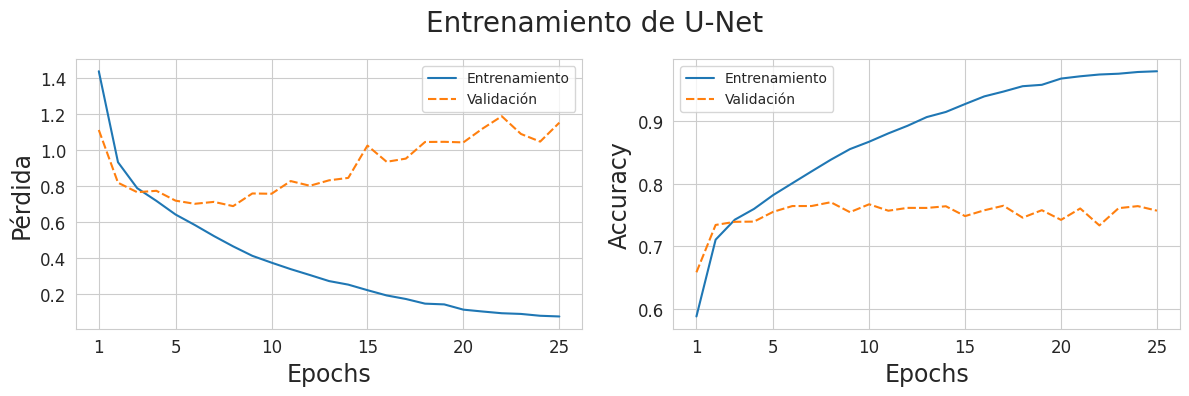

In [ ]:
plot_training_results(
    checkpoint["train_losses"],
    checkpoint["val_losses"],
    checkpoint["train_accuracies"],
    checkpoint["val_accuracies"],
    "Entrenamiento de U-Net"
)

Calculamos su *accuracy* exacta en validación y estimamos sus FPS:

In [ ]:
_ = measure_exact_accuracy_unet(model, val_dataset, val_dataloader)

100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


Accuracy: 0.7701


In [ ]:
_ = measure_fps_unet(model, val_dataset, val_dataloader)

FPS: 23.97


## Comparación con FCN

Vamos a comparar U-Net con la FCN entrenada en fcn.ipynb. Comenzamos cargando los checkpoints de los mejores modelos encontrados para ambas arquitecturas:

In [ ]:
model_unet = UNet().to(DEVICE)
checkpoint = torch.load("/content/drive/MyDrive/tfg/models/unet.pth", weights_only=False)
model_unet.load_state_dict(checkpoint["best_model"]["model_state_dict"])

model_fcn, _ = get_model_fcn(9)
checkpoint = torch.load("/content/drive/MyDrive/tfg/models/fcn.pth", weights_only=False)
model_fcn.load_state_dict(checkpoint["best_model"]["model_state_dict"])

<All keys matched successfully>

Elaboramos la matriz de confusión conjunta de ambos modelos:

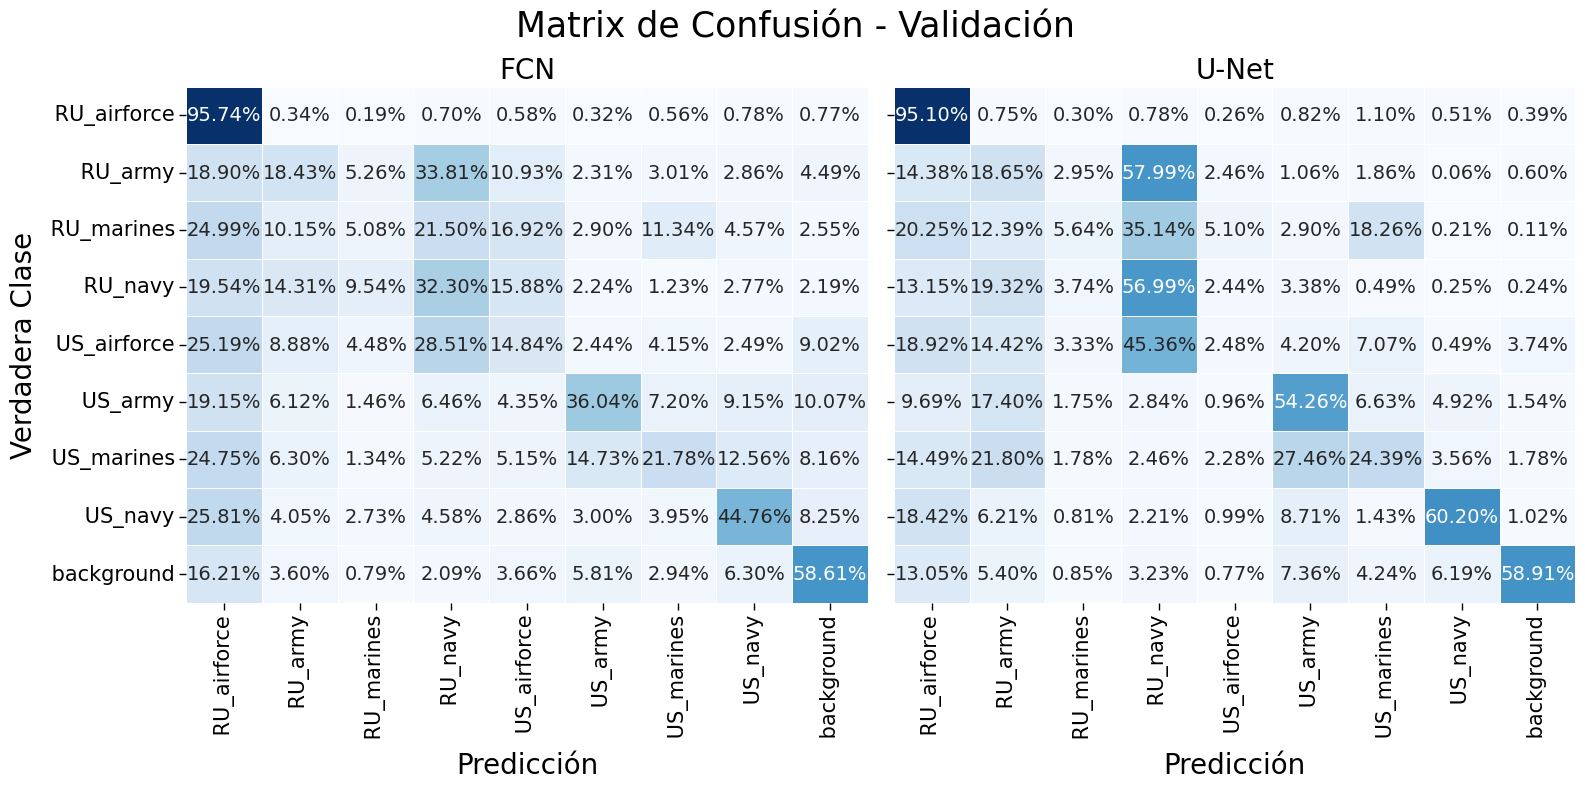

In [ ]:
sns.set_context("paper")
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

num_labels = len(label_encoder.classes_)

# FCN
true_masks = []
predicted_masks = []

for image, mask in val_dataset:
    true_masks.append(mask)
    predicted_masks.append(predict_fcn(image, model_fcn))

cf_matrix = np.zeros((num_labels, num_labels))

for true_mask, predicted_mask in zip(true_masks, predicted_masks):
    cf_matrix += confusion_matrix(
        true_mask.flatten(),
        predicted_mask.flatten(),
        labels=label_encoder.transform(label_encoder.classes_)
    )

cf_matrix_percentage = cf_matrix / cf_matrix.sum(axis=1).reshape(-1, 1)
labs = label_encoder.inverse_transform(range(len(label_encoder.classes_)))
df_cf_matrix_percentage = pd.DataFrame(cf_matrix_percentage)
df_cf_matrix_percentage.index = label_encoder.classes_
df_cf_matrix_percentage.columns = label_encoder.classes_

group_percentages = ["{0:.2%}".format(value) for value in (
    cf_matrix/np.sum(cf_matrix, axis = 1).reshape(-1,1)).flatten()]
cf_labels = np.asarray([f"{v1}" for v1 in group_percentages]).reshape(
    len(label_encoder.classes_), len(label_encoder.classes_))

cf_plot_fcn = sns.heatmap(df_cf_matrix_percentage,
            annot=cf_labels,
            cmap="Blues", fmt="", linewidth=0.5, linecolor = "white",
            annot_kws={"size": 14}, ax = axs[0], cbar=False)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=15)
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=0, fontsize=15)
axs[0].set_title("FCN", fontsize=20)
axs[0].set_xlabel("Predicción", fontsize=20)
axs[0].set_ylabel("Verdadera Clase", fontsize=20)


# U-Net
true_masks = []
predicted_masks = []

for image, mask in val_dataset:
    true_masks.append(mask)
    predicted_masks.append(predict_unet(image, model_unet))

cf_matrix = np.zeros((num_labels, num_labels))

for true_mask, predicted_mask in zip(true_masks, predicted_masks):
    cf_matrix += confusion_matrix(
        true_mask.flatten(),
        predicted_mask.flatten(),
        labels=label_encoder.transform(label_encoder.classes_)
    )

cf_matrix_percentage = cf_matrix / cf_matrix.sum(axis=1).reshape(-1, 1)
labs = label_encoder.inverse_transform(range(len(label_encoder.classes_)))
df_cf_matrix_percentage = pd.DataFrame(cf_matrix_percentage)
df_cf_matrix_percentage.index = label_encoder.classes_
df_cf_matrix_percentage.columns = label_encoder.classes_

group_percentages = ["{0:.2%}".format(value) for value in (
    cf_matrix/np.sum(cf_matrix, axis = 1).reshape(-1,1)).flatten()]
cf_labels = np.asarray([f"{v1}" for v1 in group_percentages]).reshape(
    len(label_encoder.classes_), len(label_encoder.classes_))

cf_plot_fcn = sns.heatmap(df_cf_matrix_percentage,
            annot=cf_labels,
            cmap="Blues", fmt="", linewidth=0.5, linecolor = "white",
            annot_kws={"size": 14}, ax = axs[1], cbar=False)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=15)
axs[1].set_yticklabels("")
axs[1].set_title("U-Net", fontsize=20)
axs[1].set_ylabel("")
axs[1].set_xlabel("Predicción", fontsize=20)

fig.suptitle("Matrix de Confusión - Validación", fontsize=25)

plt.tight_layout()

plt.show()



Hacemos una comparación de predicciones para algunas imágenes:

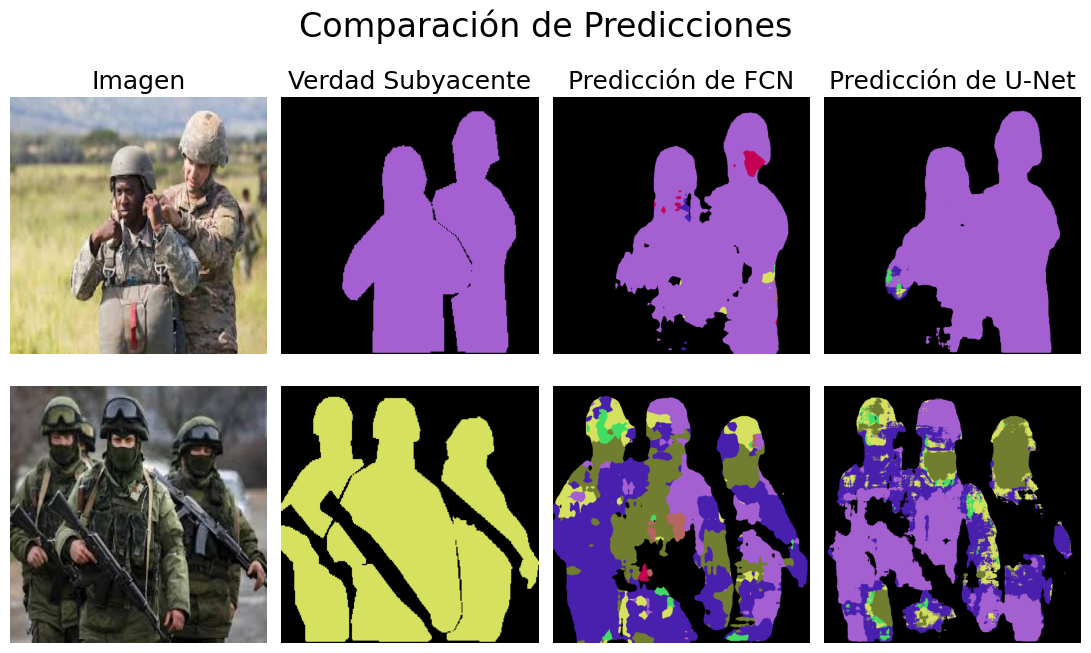

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(11, 7))

# Imagen de arriba
image, mask = val_dataset[19]
axs[0, 0].imshow(image)
axs[0, 0].axis("off")
axs[0, 0].set_title("Imagen", fontsize=18)
axs[0, 1].imshow(color_mask(mask, MAPPING_MATRIX))
axs[0, 1].axis("off")
axs[0, 1].set_title("Verdad Subyacente", fontsize=18)
axs[0, 2].imshow(color_mask(predict_fcn(image, model_fcn), MAPPING_MATRIX))
axs[0, 2].axis("off")
axs[0, 2].set_title("Predicción de FCN", fontsize=18)
axs[0, 3].imshow(color_mask(predict_unet(image, model_unet), MAPPING_MATRIX))
axs[0, 3].axis("off")
axs[0, 3].set_title("Predicción de U-Net", fontsize=18)

# Imagen de abajo
image, mask = val_dataset[1]
axs[1, 0].imshow(image)
axs[1, 0].axis("off")
axs[1, 1].imshow(color_mask(mask, MAPPING_MATRIX))
axs[1, 1].axis("off")
axs[1, 2].imshow(color_mask(predict_fcn(image, model_fcn), MAPPING_MATRIX))
axs[1, 2].axis("off")
axs[1, 3].imshow(color_mask(predict_unet(image, model_unet), MAPPING_MATRIX))
axs[1, 3].axis("off")

fig.suptitle("Comparación de Predicciones", fontsize=24)
plt.tight_layout()
plt.show()

## Desempeño sobre el Conjunto Test

Como U-Net resulta ser el mejor modelo, lo evaluamos sobre el conjunto test. Comenzamos calculando su *accuracy* y estimando sus FPS sobre este conjunto:

In [ ]:
_ = measure_exact_accuracy_unet(model_unet, test_dataset, test_dataloader)

100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


Accuracy: 0.7701


In [ ]:
_ = measure_fps_unet(model_unet, test_dataset, test_dataloader)

FPS: 24.09


Elaboramos la matriz de confusión sobre este conjunto:

In [ ]:
true_masks = []
predicted_masks = []

for image, mask in test_dataset:
    true_masks.append(mask)
    predicted_masks.append(predict_unet(image, model_unet))

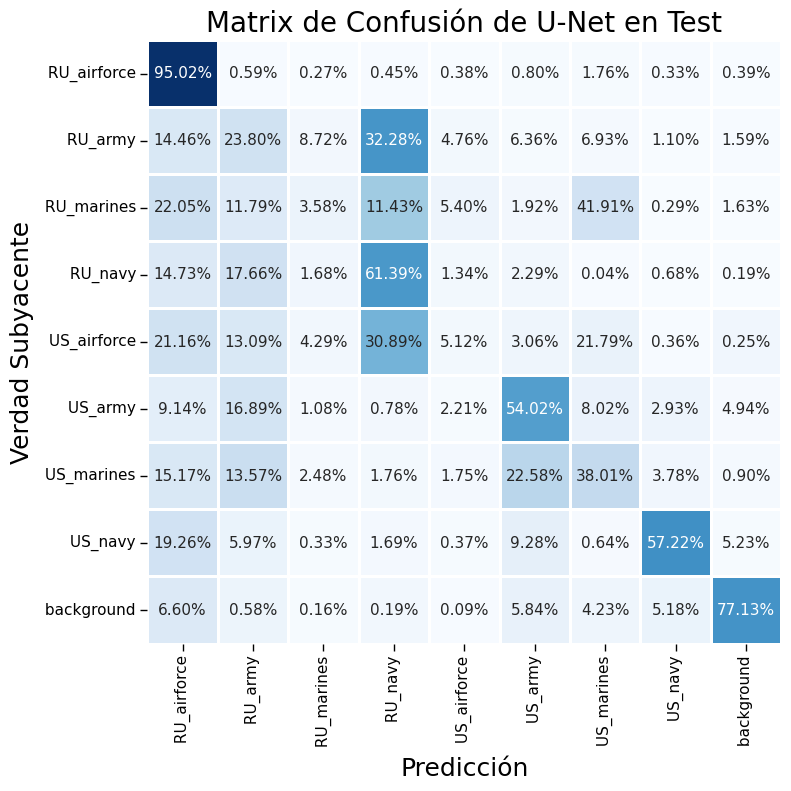

In [ ]:
_, _ = create_confusion_matrix_segmentation(true_masks, predicted_masks,
                                      label_encoder,
                                      title="Matrix de Confusión de U-Net en Test")

Predecimos sobre dos imágenes:

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(9, 7))

# Imagen de arriba
image, mask = test_dataset[6]
axs[0, 0].imshow(image)
axs[0, 0].axis("off")
axs[0, 0].set_title("Imagen", fontsize=18)
axs[0, 1].imshow(color_mask(mask, MAPPING_MATRIX))
axs[0, 1].axis("off")
axs[0, 1].set_title("Verdad Subyacente", fontsize=18)
axs[0, 2].imshow(color_mask(predict_unet(image, model_unet), MAPPING_MATRIX))
axs[0, 2].axis("off")
axs[0, 2].set_title("Predicción", fontsize=18)

# Imagen de abajo
image, mask = test_dataset[5]
axs[1, 0].imshow(image)
axs[1, 0].axis("off")
axs[1, 1].imshow(color_mask(mask, MAPPING_MATRIX))
axs[1, 1].axis("off")
axs[1, 2].imshow(color_mask(predict_unet(image, model_unet), MAPPING_MATRIX))
axs[1, 2].axis("off")

fig.suptitle("Desempeño de U-Net en el Conjunto Test", fontsize=24)
plt.tight_layout()
plt.show()